## Description
In the previous notebooks, we performed analysis on the vocabularies, and now we have the ability to map abbreviations back to dictioanry words, I would like to perform analysis after abbreviation. 

In [1]:
import pandas as pd
import sqlite3
name_table = "NameTable"
conn = sqlite3.connect('data.db')
query = f"SELECT * FROM {name_table}"
df = pd.read_sql_query(query, conn)
import json
df['terms'] = df.terms.apply(json.loads)
df

,id,name,nameType,nameScope,projectSize,authorName,authorProficiency,authorLocation,terms,namingConvention
0,0,_raise_err,function,GlobalScope,72400,programthink,<50,China,"[raise, err]",Snake
1,1,_load_yaml,function,GlobalScope,72400,programthink,<50,China,"[load, yaml]",Snake
2,2,Node,class,GlobalScope,72400,programthink,<50,China,[Node],Pascal
3,3,Relation,class,GlobalScope,72400,programthink,<50,China,[Relation],Pascal
4,4,Family,class,GlobalScope,72400,programthink,<50,China,[Family],Pascal
...,...,...,...,...,...,...,...,...,...,...
8234210,8234210,__long__,variable,FunctionScope,10460,juvers,>100,USA,[long],Snake
8234211,8234211,__getslice__,variable,FunctionScope,10460,juvers,>100,USA,[getslice],Snake
8234212,8234212,__setslice__,variable,FunctionScope,10460,juvers,>100,USA,[setslice],Snake
8234213,8234213,__delslice__,variable,FunctionScope,10460,juvers,>100,USA,[delslice],Snake


In [2]:
abbrev_table = "AbbreviationMap"
query = f"SELECT * FROM {abbrev_table}"
df_abbrev_map = pd.read_sql_query(query, conn)

In [3]:
# pd.set_option('display.max_columns', None)

df_abbrev_map[90:100]

,term,name,abbrev_meaning
90,tgt,tgt,target
91,auth,_basic_auth_str,authorization
92,cfg,cfg,configuration
93,dt,test_find_records_dt,date
94,Calc,testCalcReductionLayers,calculation
95,html,html_theme,HTML theme
96,resp,resp,response
97,loc,loc,location
98,py,is_py2,Python 2
99,attn,attn_output,attention output


Since we are converting abbreviations back to original words. But we will have too look into the vocabularies now. And tokenizations - The interesting things here is that we want to see what would having no abbreviation affects the full name analysis, and also we need to do a brief analysis on abbreviation, answer questions such as "what is the percentage of ussage of abbreviation"?  


## Convert abbreviations back to real words

In [ ]:
# I will use a better dictionary: ENABLE (Enhanced North American Benchmark Lexicon)
with open('SavedFiles/atebits.txt', 'r') as file:
    words = file.read().splitlines()
english_dictionary =  set(words)

# the dictionary that maps abbreviation back to original words
abbrev_map = dict(zip(df_abbrev_map['term'], df_abbrev_map['abbrev_meaning']))
# because the confidence of preicting single letter is too low, I would give up all the single letters
# also there are ones that ChatGPT cannot recognize, generally too wierd ones, so I will get rid of those too. (277 of them)
# also there are about 20k duplicates due to capitalization, here we will combine them together first. ???
filtered_abbrev_map = {k: v for k, v in abbrev_map.items() if v != '-1'}

# function that checks if it's a real word
def lookup_terms(term):
    return term.lower() in english_dictionary

len(filtered_abbrev_map)

In [5]:
def map_terms_to_actual_terms(terms):
    # if it's dictionary word, it will not be in the dictionary, or it might be something that GPT cannot guess. 
    # either way, the original terms will be in the list. Else, the translated terms will be in the list.
    return [filtered_abbrev_map.get(term, term) for term in terms]

df['actual_terms'] = df['terms'].apply(map_terms_to_actual_terms)       

In [6]:
temp = df['terms'].apply('_'.join).str.lower()
df['standarized_name'] = temp



In [7]:
temp = df['actual_terms'].apply('_'.join).str.lower().str.replace(" ", "_")
df['atual_standarized_name'] = temp

In [8]:
# we use atual_standarized_name to define actual_terms so that we can get rid of the space
# sometimes pd will return view of df not the actual df, depends on the RAM
df = df.copy()
df['actual_terms'] = df['atual_standarized_name'].apply(lambda x: x.split('_'))

In [9]:
df

,id,name,nameType,nameScope,projectSize,authorName,authorProficiency,authorLocation,terms,namingConvention,actual_terms,standarized_name,atual_standarized_name
0,0,_raise_err,function,GlobalScope,72400,programthink,<50,China,"[raise, err]",Snake,"[raise, err]",raise_err,raise_err
1,1,_load_yaml,function,GlobalScope,72400,programthink,<50,China,"[load, yaml]",Snake,"[load, yaml]",load_yaml,load_yaml
2,2,Node,class,GlobalScope,72400,programthink,<50,China,[Node],Pascal,[node],node,node
3,3,Relation,class,GlobalScope,72400,programthink,<50,China,[Relation],Pascal,[relation],relation,relation
4,4,Family,class,GlobalScope,72400,programthink,<50,China,[Family],Pascal,[family],family,family
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8234210,8234210,__long__,variable,FunctionScope,10460,juvers,>100,USA,[long],Snake,[long],long,long
8234211,8234211,__getslice__,variable,FunctionScope,10460,juvers,>100,USA,[getslice],Snake,"[get, slice]",getslice,get_slice
8234212,8234212,__setslice__,variable,FunctionScope,10460,juvers,>100,USA,[setslice],Snake,"[set, slice]",setslice,set_slice
8234213,8234213,__delslice__,variable,FunctionScope,10460,juvers,>100,USA,[delslice],Snake,"[delete, slice]",delslice,delete_slice


# Length

In [10]:
import re
def count_length_by_letter(name):
    # we don't count numbers and underscore
    pattern = r'[0-9_]'
    name = re.sub(pattern, '', name)
    return len(name)
    
df["lengthByLetter"] = df['atual_standarized_name'].apply(count_length_by_letter)
df['lengthByWord'] = df['atual_standarized_name'].apply(lambda s: s.count('_') + 1)
df = df[(df['lengthByLetter'] > 0) & (df['lengthByWord'] > 0)]

## Length By Letter

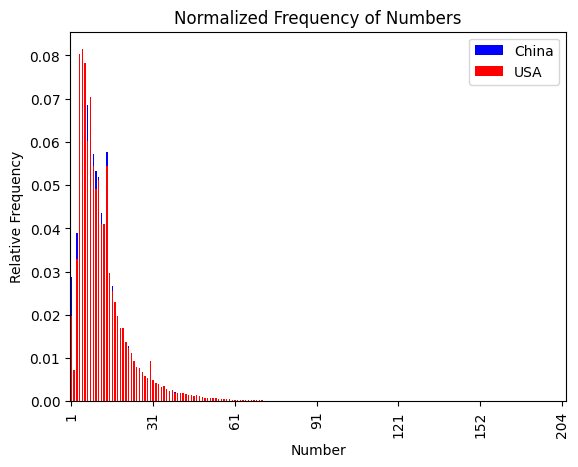

In [11]:
df_chinese_letter_len_freq = df[df['authorLocation'] == 'China']['lengthByLetter'].value_counts(normalize=True).sort_index()
df_english_letter_len_freq = df[df['authorLocation'] == 'USA']['lengthByLetter'].value_counts(normalize=True).sort_index()
import matplotlib.pyplot as plt
df_chinese_letter_len_freq.plot(kind='bar', color='blue', label='China')
df_english_letter_len_freq.plot(kind='bar', color='red', label='USA')
# Adding labels and title
plt.xlabel('Number')
plt.ylabel('Relative Frequency')
plt.title('Normalized Frequency of Numbers')
plt.legend()
# show less x labels
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(7))  # Adjust '5' to display the desired number of ticks

# Showing the plot
plt.show()

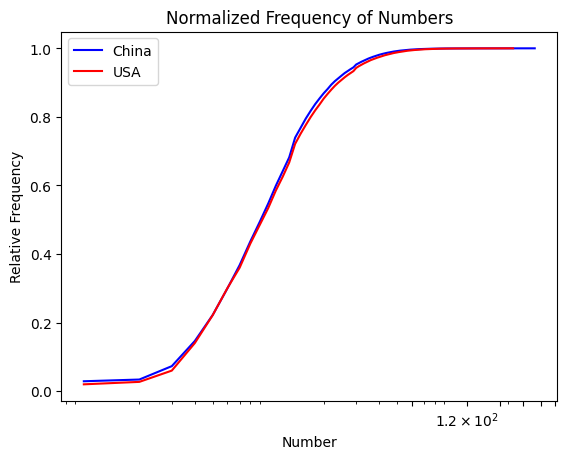

In [43]:
import matplotlib.pyplot as plt
# df_brown_letter_len_freq.cumsum().plot(kind='bar', color='green', label='Brown')
df_chinese_letter_len_freq.cumsum().plot(kind='line', color='blue', label='China')
df_english_letter_len_freq.cumsum().plot(kind='line', color='red', label='USA')
# Adding labels and title
plt.xlabel('Number')
plt.ylabel('Relative Frequency')
plt.title('Normalized Frequency of Numbers')
plt.legend()
plt.xscale('log')  # Set y-axis to logarithmic scale

# show less x labels
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(7))  # Adjust '5' to display the desired number of ticks

# Showing the plot
plt.show()

## Length By Word

In [13]:
print("Average Length (by word) of Chinese-speaking Programmers are: ")
print(df[df['authorLocation'] == 'China']['lengthByWord'].mean())
print("Average Length (by word) of English-speaking Programmers are: ")
print(df[df['authorLocation'] == 'USA']['lengthByWord'].mean())

Average Length (by word) of Chinese-speaking Programmers are: 
2.0784802154025415
Average Length (by word) of English-speaking Programmers are: 
2.1577020494430887


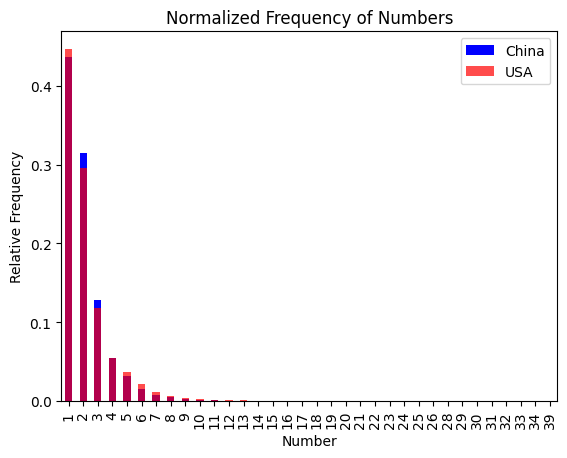

In [14]:
df_chinese_word_len_freq = df[df['authorLocation'] == 'China']['lengthByWord'].value_counts(normalize=True).sort_index()
df_english_word_len_freq = df[df['authorLocation'] == 'USA']['lengthByWord'].value_counts(normalize=True).sort_index()

df_chinese_word_len_freq.plot(kind='bar', color='blue', label='China')
df_english_word_len_freq.plot(kind='bar', color='red', label='USA', alpha=0.7, position=0.5)
# Adding labels and title
plt.xlabel('Number')
plt.ylabel('Relative Frequency')
plt.title('Normalized Frequency of Numbers')
plt.legend()
# Showing the plot
plt.show()

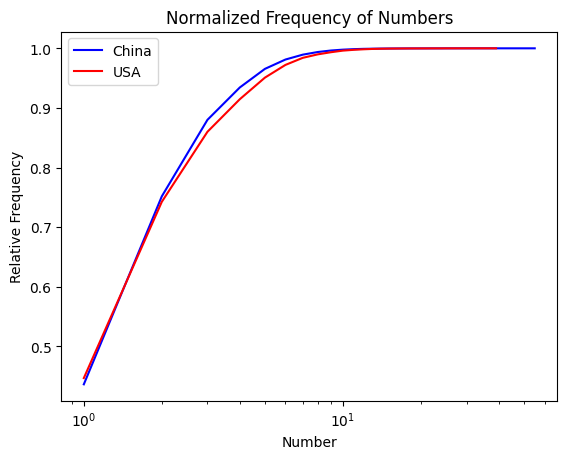

In [44]:
df_chinese_word_len_freq.cumsum().plot(kind='line', color='blue', label='China')
df_english_word_len_freq.cumsum().plot(kind='line', color='red', label='USA')
# Adding labels and title
plt.xlabel('Number')
plt.ylabel('Relative Frequency')
plt.title('Normalized Frequency of Numbers')
plt.xscale('log')  # Set y-axis to logarithmic scale

plt.legend()
# Showing the plot
plt.show()

## Length by Letter and by Word

In [16]:
def plot_letterXword(df_language):
    # assume that the dataframe have both lengthByLetter and lengthByWord columns. 
    df_letterXword_len_freq = df_language.groupby(['lengthByLetter', 'lengthByWord']).size().reset_index(name='count')
    # pivot the dataframe
    pivot_df = df_letterXword_len_freq.pivot(index='lengthByLetter', columns='lengthByWord', values='count').fillna(0)
    # plot the dataframe
    pivot_df.plot(kind='bar', stacked=True)
    plt.xlabel('Length by Letter')
    plt.ylabel('Count')
    plt.title('Stacked Bar Plot of Length by Letter with Length by Word')
    plt.legend(title='Length by Word')
    plt.show()

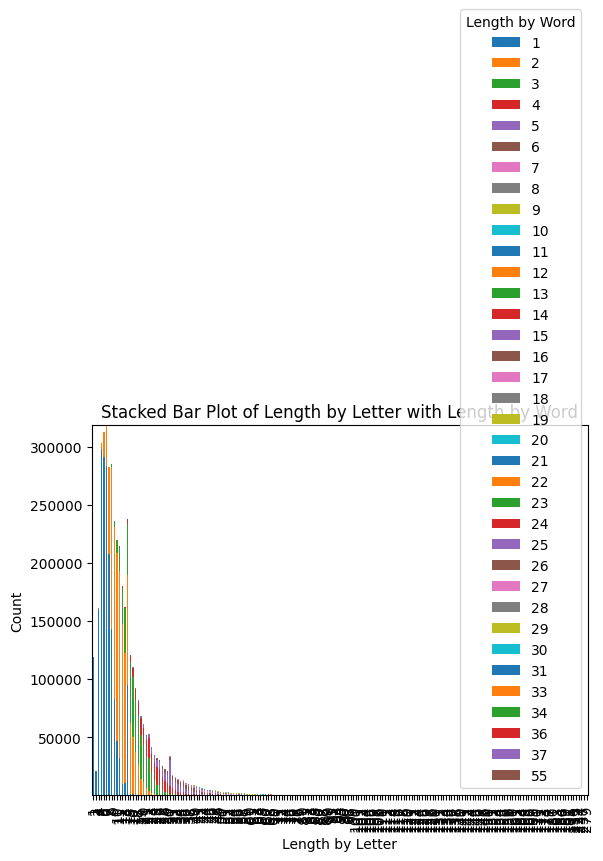

In [17]:
plot_letterXword(df[df['authorLocation'] == 'China'])


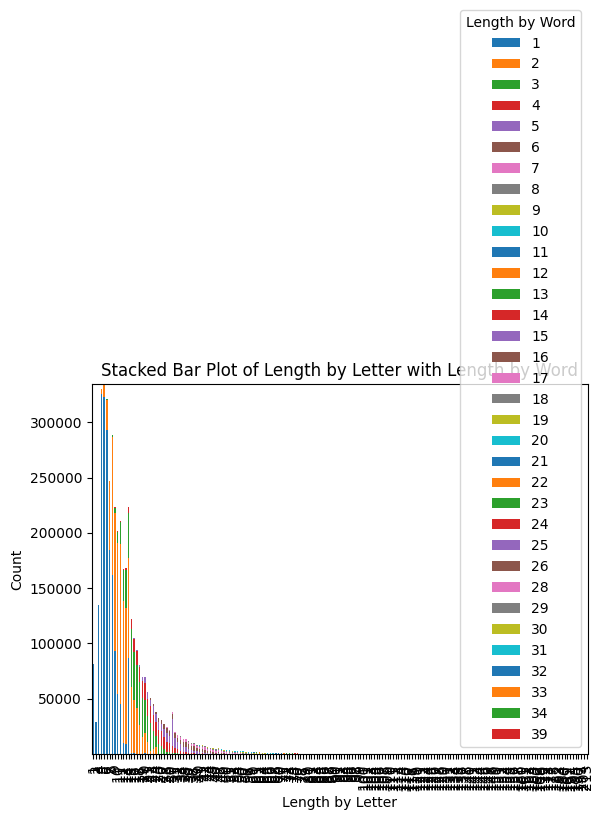

In [18]:
plot_letterXword(df[df['authorLocation'] == 'USA'])

# Most Common Terms

## By Word

In [45]:
flattened_words_chinese = df[df['authorLocation'] == 'China']['terms'].explode()
# Count the occurrences of each word
word_counts_chinese = flattened_words_chinese.value_counts()
word_counts_chinese.head(40)

terms
test        202517
get          96318
init         92734
name         59047
x            56367
data         51644
path         37470
y            36314
result       35207
value        29471
X            29364
set          28379
model        28056
output       27408
out          26404
list         26341
to           26027
type         24448
Test         23793
is           23787
new          23555
n            23219
size         23217
file         21798
msg          21762
input        21715
all          21125
d            20925
id           20600
a            20571
create       19509
s            19392
check        19343
info         19017
num          18759
res          18525
mask         18395
loss         18377
key          18234
expected     17821
Name: count, dtype: int64

In [46]:
flattened_words_english = df[df['authorLocation'] == 'USA']['terms'].explode()
# Count the occurrences of each word
word_counts_english = flattened_words_english.value_counts()
word_counts_english.head(40)

terms
test        164225
ID           94234
init         80988
get          75667
result       59128
block        57226
name         54294
data         37457
expected     32900
item         31789
x            31201
value        31136
path         30085
is           27800
to           25521
a            25334
set          23273
more         22273
Wood         20799
s            20644
new          20360
type         20061
Test         19880
output       18813
version      18348
c            18044
d            17774
url          17549
D            17480
res          17468
df           17435
y            17402
msg          17393
all          17117
key          17068
check        16923
model        16852
index        16814
from         16792
text         16322
Name: count, dtype: int64

Check if they are the same set of single letters

In [47]:
dic_chinese_frequent_words = word_counts_chinese.head(40).to_dict()
dic_english_frequent_words = word_counts_english.head(40).to_dict()

In [48]:
def compare_joint_set(dic_chinese, dic_english, single_letter=True):
    if single_letter:
        dic_chinese = {k for k in dic_chinese if len(k) == 1}
        dic_english = {k for k in dic_english if len(k) == 1}
    else:
        dic_chinese = {k for k in dic_chinese}
        dic_english = {k for k in dic_english}
    # Joint set
    joint_set = dic_chinese.union(dic_english)
    
    # Left unique (elements only in set1)
    chinese_unique = dic_chinese.difference(dic_english)
    
    # Right unique (elements only in set2)
    english_unique = dic_english.difference(dic_chinese)
    
    print("Joint set:", joint_set)
    print("chinese unique:", chinese_unique)
    print("english unique:", english_unique)

compare_joint_set(dic_chinese_frequent_words, dic_english_frequent_words)


Joint set: {'y', 'X', 'd', 'a', 's', 'x', 'D', 'n', 'c'}
chinese unique: {'n', 'X'}
english unique: {'D', 'c'}


In [49]:
compare_joint_set(dic_chinese_frequent_words, dic_english_frequent_words, single_letter=False)

Joint set: {'model', 'all', 'size', 'Test', 'mask', 'to', 'df', 'ID', 'more', 'index', 'c', 'from', 'create', 'res', 'D', 'key', 'input', 'version', 'y', 's', 'result', 'info', 'd', 'file', 'item', 'out', 'init', 'n', 'url', 'type', 'is', 'Wood', 'expected', 'value', 'loss', 'output', 'num', 'new', 'name', 'path', 'a', 'msg', 'x', 'list', 'data', 'test', 'id', 'text', 'X', 'set', 'block', 'check', 'get'}
chinese unique: {'info', 'id', 'num', 'list', 'mask', 'X', 'file', 'create', 'out', 'loss', 'input', 'n', 'size'}
english unique: {'text', 'block', 'Wood', 'df', 'from', 'version', 'D', 'ID', 'item', 'more', 'index', 'url', 'c'}


## By Full Name

In [24]:
name_counts_chinese = df[df['authorLocation'] == 'China']['atual_standarized_name'].value_counts()
name_counts_chinese.head(40)

atual_standarized_name
initialization                        83337
x                                     58059
result                                27337
data                                  24630
y                                     21522
name                                  20888
message                               20602
value                                 20462
index                                 17329
alpha                                 16864
out                                   15817
token_pretrained_sequence_to_graph    15440
res                                   14099
c                                     13663
forward                               13105
frequency_delta                       12794
ret                                   12675
response                              12624
path                                  12588
model                                 11812
beta                                  11333
image                                 10904
output   

In [25]:
name_counts_english = df[df['authorLocation'] == 'USA']['atual_standarized_name'].value_counts()
name_counts_english.head(40)

atual_standarized_name
initialization                        75872
result                                53612
x                                     30194
expected                              26450
name                                  24778
index                                 23739
value                                 23399
alpha                                 22497
data                                  22478
message                               19178
token_pretrained_sequence_to_graph    17703
more                                  16607
res                                   15859
dataframe                             15137
c                                     14893
y                                     13532
beta                                  13290
path                                  12478
delta                                 12236
radius                                11043
key                                   10820
frequency_delta                       10444
current_a

In [26]:
dic_chinese_frequent_names = name_counts_chinese.head(40).to_dict()
dic_english_frequent_names = name_counts_english.head(40).to_dict()

In [27]:
compare_joint_set(dic_chinese_frequent_names, dic_english_frequent_names)


Joint set: {'p', 'y', 'x', 'n', 'c'}
chinese unique: {'n'}
english unique: set()


In [28]:
compare_joint_set(dic_chinese_frequent_names, dic_english_frequent_names, single_letter=False)


Joint set: {'return_value', 'forward', 'response', 'model', 'all', 'alpha', 'radius', 'p', 'more', 'index', 'c', 'exit', 'description', 'current_answer', 'initialization', 'res', 'dataframe', 'key', 'version', 'beta', 'representation', 'y', 'string', 'result', 'message', 'delta', 'values', 'time', 'out', 'token_pretrained_sequence_to_graph', 'n', 'context', 'call', 'length', 'expected', 'value', 'arguments', 'image', 'output', 'name', 'path', 'x', 'data', 'velocity', 'request', 'ret', 'text', 'frequency_delta', 'mass'}
chinese unique: {'context', 'ret', 'output', 'forward', 'model', 'time', 'request', 'n', 'image'}
english unique: {'exit', 'return_value', 'call', 'description', 'values', 'current_answer', 'expected', 'dataframe', 'more'}


# Zipf Law

In [29]:
series_chinese_std_name_freq = df[df['authorLocation'] == 'China']['atual_standarized_name'].value_counts(normalize=True).sort_index()
df_chinese_atcual_std_name_freq = pd.DataFrame(series_chinese_std_name_freq.reset_index())
df_chinese_atcual_std_name_freq.rename(columns={"proportion": "frequency", 'atual_standarized_name': 'terms'}, inplace=True)

series_english_std_name_freq = df[df['authorLocation'] == 'USA']['atual_standarized_name'].value_counts(normalize=True).sort_index()
df_english_atcual_std_name_freq = pd.DataFrame(series_english_std_name_freq.reset_index())
df_english_atcual_std_name_freq.rename(columns={"proportion": "frequency", 'atual_standarized_name': 'terms'}, inplace=True)

In [30]:
series_chinese_std_name_freq = df[df['authorLocation'] == 'China']['standarized_name'].value_counts(normalize=True).sort_index()
df_chinese_std_name_freq = pd.DataFrame(series_chinese_std_name_freq.reset_index())
df_chinese_std_name_freq.rename(columns={"proportion": "frequency", 'standarized_name': 'terms'}, inplace=True)

series_english_std_name_freq = df[df['authorLocation'] == 'USA']['standarized_name'].value_counts(normalize=True).sort_index()
df_english_std_name_freq = pd.DataFrame(series_english_std_name_freq.reset_index())
df_english_std_name_freq.rename(columns={"proportion": "frequency", 'standarized_name': 'terms'}, inplace=True)

In [31]:
import matplotlib.pyplot as plt
def print_zipfs_law(df_word_freq, label):
    # assume the two columns are named "terms" and "frequency"
    df_word_freq['rank'] = df_word_freq['frequency'].rank(ascending=False)
    # for the same rank there might be more than one word
    df_zipf = df_word_freq.groupby('rank').agg({'frequency': 'mean'}).reset_index()

    plt.plot(df_zipf['rank'], df_zipf['frequency'], label=label)
    
    plt.yscale('log')  # Set y-axis to logarithmic scale
    plt.xscale('log')  # Set y-axis to logarithmic scale
    plt.xlabel('Rank of Word')
    plt.ylabel('Frequency')
    plt.title('Word Frequency Distribution')
    plt.legend()
    plt.grid(True)

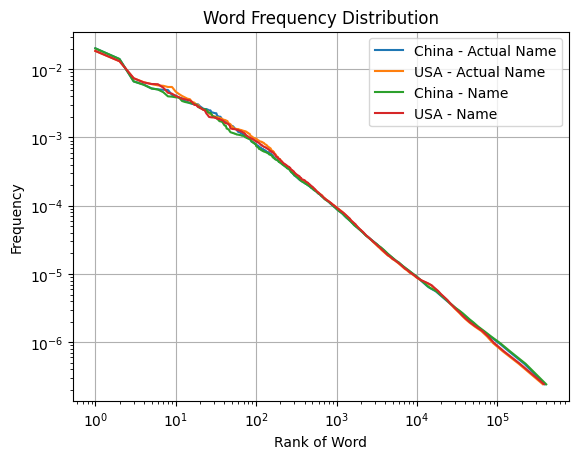

In [32]:
print_zipfs_law(df_chinese_atcual_std_name_freq, label='China - Actual Name')
print_zipfs_law(df_english_atcual_std_name_freq, label='USA - Actual Name')
print_zipfs_law(df_chinese_std_name_freq, label='China - Name')
print_zipfs_law(df_english_std_name_freq, label='USA - Name')

## Rank bags and length by letter¶

In [33]:
def plot_rank_bag_to_letter_len(df_word_freq):
    # assume it have columns "terms" (abuse notation), and "frequency"
    df_word_freq['rank'] = df_word_freq['frequency'].rank(ascending=False)
    df_word_freq['lengthByLetter'] = df_word_freq['terms'].apply(len)
    # map rank to bins
    bins = [0, 10, 100, 1000, 10000, 100000]
    labels = ['1-10', '10-100', '100-1k', '1k-10k', '10k+']
    df_word_freq['rankBag'] = pd.cut(df_word_freq['rank'], bins=bins, labels=labels, right=False)
    # plot the boxplot for each bag: we don't show fliers
    df_word_freq.boxplot(column='lengthByLetter', by='rankBag', grid=False, patch_artist=True, showfliers=False)
    # Adding titles and labels
    plt.title('Box Plot of Name Length by Rank Bags')
    plt.suptitle('')
    plt.xlabel('Rank Bags')
    plt.ylabel('Name Length')
    plt.xticks(rotation=45)
    plt.show()

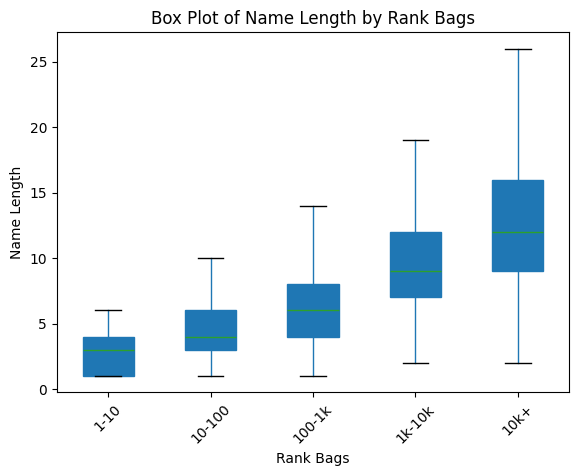

In [34]:
plot_rank_bag_to_letter_len(df_chinese_std_name_freq)

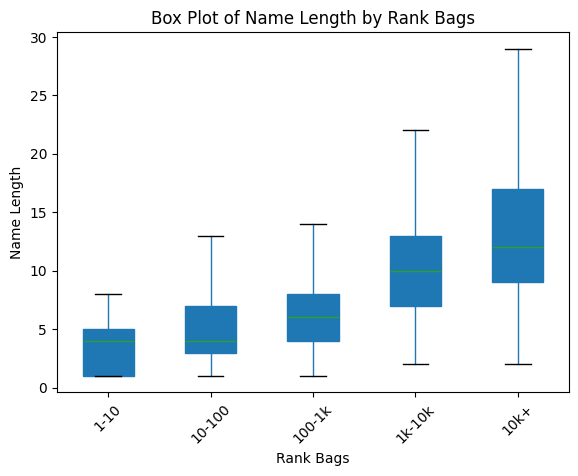

In [35]:
plot_rank_bag_to_letter_len(df_english_std_name_freq)

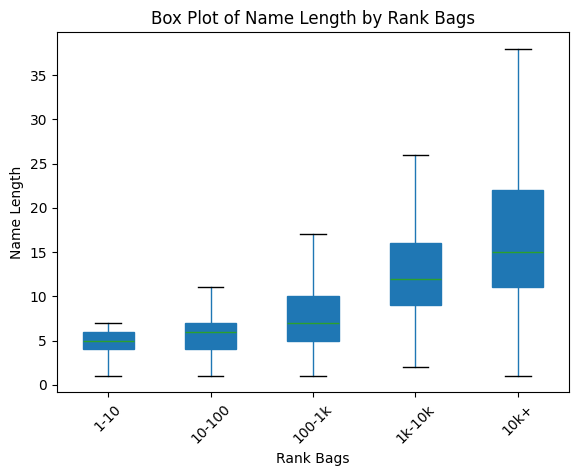

In [36]:
plot_rank_bag_to_letter_len(df_chinese_atcual_std_name_freq)

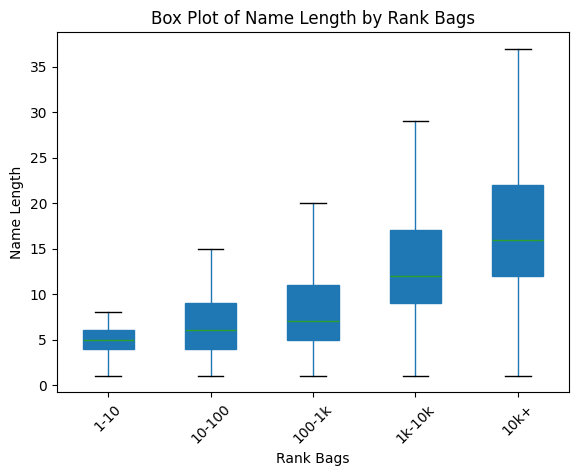

In [37]:
plot_rank_bag_to_letter_len(df_english_atcual_std_name_freq)

## Rank bags and length by word

In [38]:
def plot_rank_bag_to_word_len(df_word_freq):
    # assume it have columns "terms" (abuse notation), and "frequency"
    df_word_freq['rank'] = df_word_freq['frequency'].rank(ascending=False)
    # we assume that we will only pass standarize name - words separated by one underscore. 
    df_word_freq['lengthByWord'] = df_word_freq['terms'].apply(lambda s: s.count('_') + 1)
    # map rank to bins
    bins = [0, 10, 100, 1000, 10000, 100000]
    labels = ['1-10', '10-100', '100-1k', '1k-10k', '10k+']
    df_word_freq['rankBag'] = pd.cut(df_word_freq['rank'], bins=bins, labels=labels, right=False)
    # calculate for each rankBag, what is the number of each length number
    pivot_df = df_word_freq.pivot_table(index='rankBag', columns='lengthByWord', aggfunc='size', fill_value=0)
    pivot_df = pivot_df.div(pivot_df.sum(axis=1), axis=0)
    # plot the boxplot for each bag: we don't show fliers
    pivot_df.plot(kind='bar', stacked=True, figsize=(10, 6))
    # Adding titles and labels
    plt.title('Percentage of Name Length (by letter) by Rank Bags')
    plt.xlabel('Rank Bags')
    plt.ylabel('Name Length')
    plt.xticks(rotation=45)
    plt.legend(title='Length', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

/var/folders/2q/npr5yhgs2_553xj46qkrcsdh0000gn/T/ipykernel_952/3591105724.py:11: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_df = df_word_freq.pivot_table(index='rankBag', columns='lengthByWord', aggfunc='size', fill_value=0)


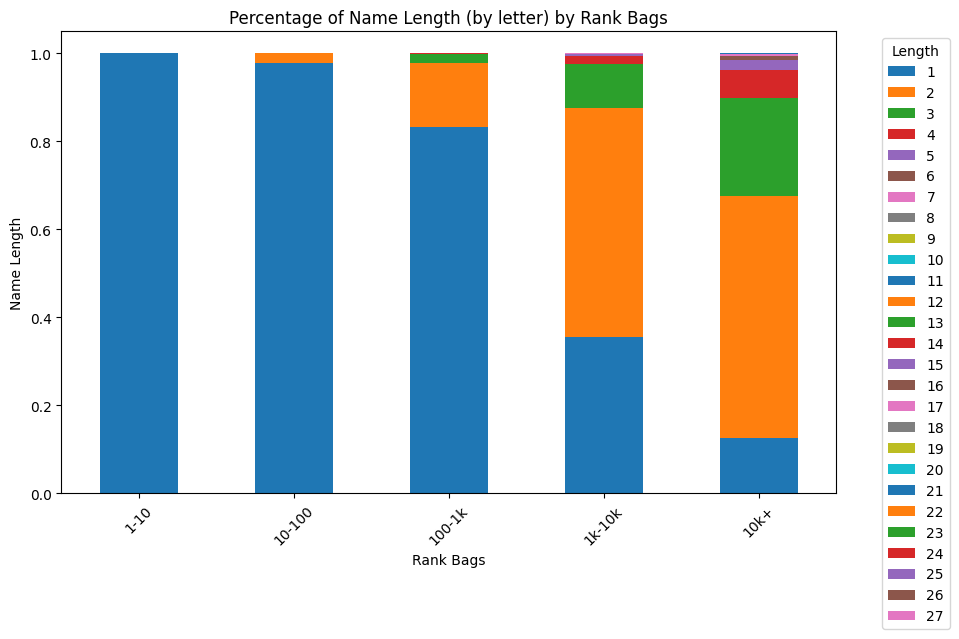

In [39]:
plot_rank_bag_to_word_len(df_chinese_std_name_freq)

/var/folders/2q/npr5yhgs2_553xj46qkrcsdh0000gn/T/ipykernel_952/3591105724.py:11: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_df = df_word_freq.pivot_table(index='rankBag', columns='lengthByWord', aggfunc='size', fill_value=0)


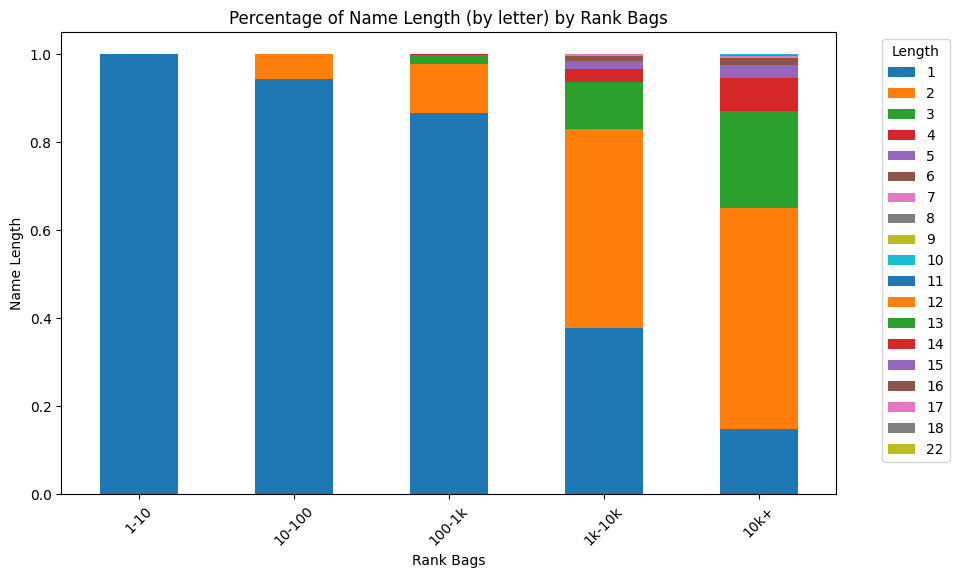

In [40]:
plot_rank_bag_to_word_len(df_english_std_name_freq)

/var/folders/2q/npr5yhgs2_553xj46qkrcsdh0000gn/T/ipykernel_952/3591105724.py:11: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_df = df_word_freq.pivot_table(index='rankBag', columns='lengthByWord', aggfunc='size', fill_value=0)


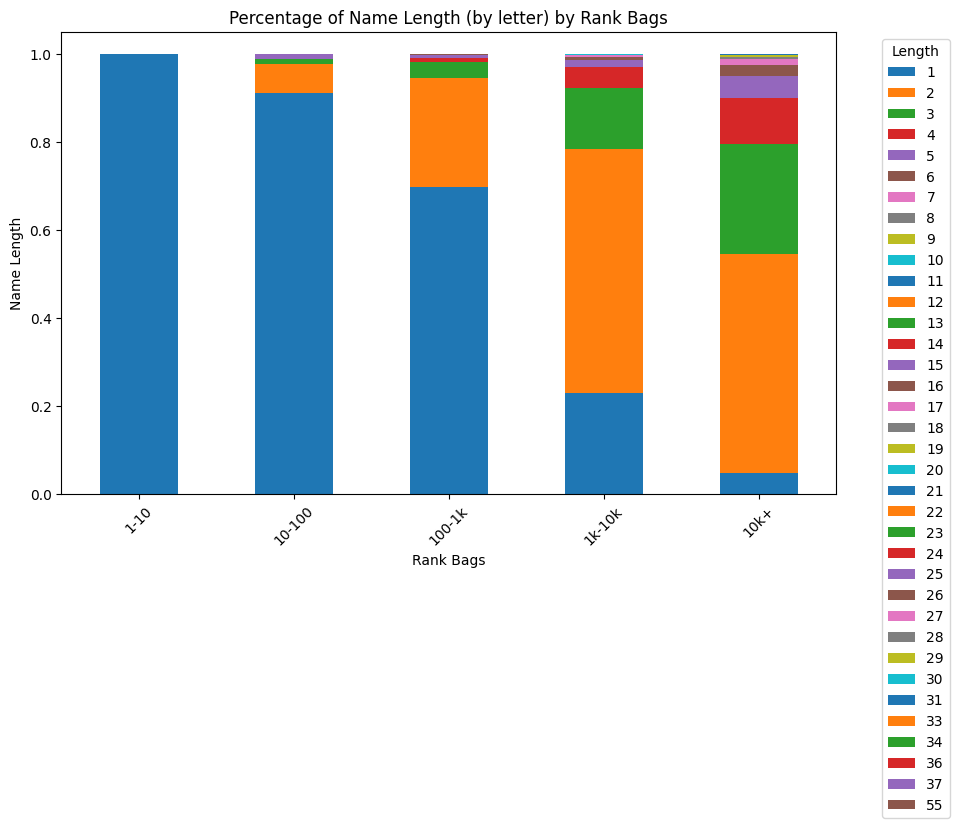

In [41]:
plot_rank_bag_to_word_len(df_chinese_atcual_std_name_freq)

/var/folders/2q/npr5yhgs2_553xj46qkrcsdh0000gn/T/ipykernel_952/3591105724.py:11: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_df = df_word_freq.pivot_table(index='rankBag', columns='lengthByWord', aggfunc='size', fill_value=0)


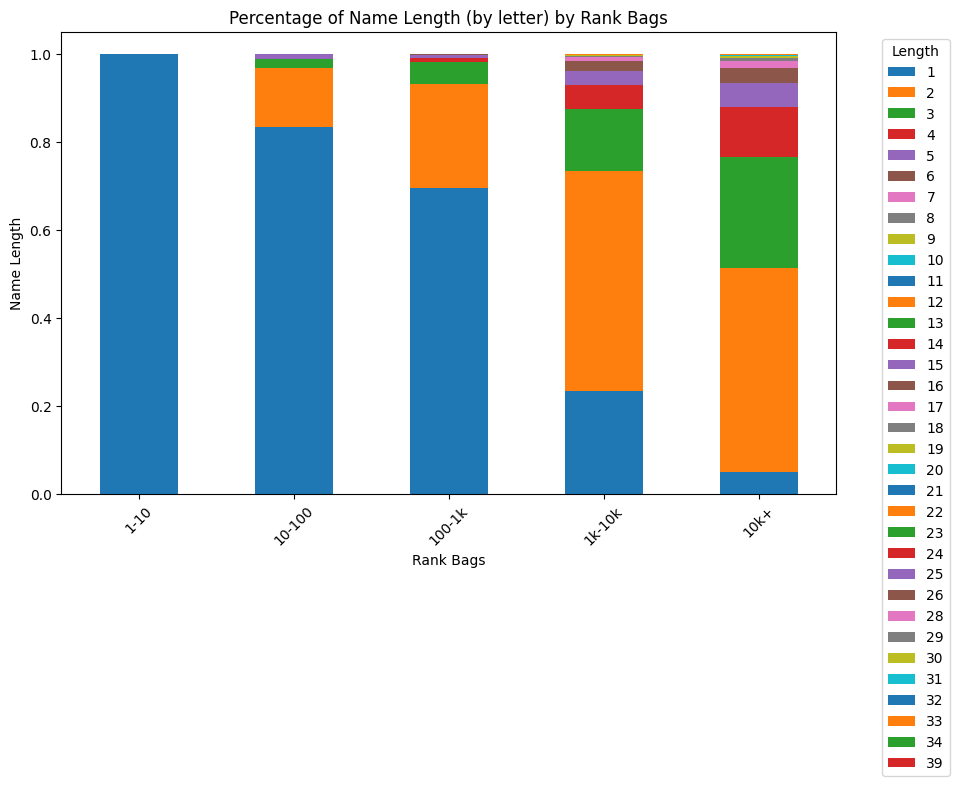

In [42]:
plot_rank_bag_to_word_len(df_english_atcual_std_name_freq)